### Import libraries and shit

In [1]:
from pymatgen.io.vasp.outputs import BSVasprun
from pymatgen.electronic_structure.plotter import BSPlotter, BSPlotterProjected
import matplotlib.lines as mlines
from pymatgen.util.plotting import pretty_plot
import matplotlib.pyplot as plt
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.symmetry.kpath import KPathLatimerMunro
from pymatgen.symmetry.bandstructure import HighSymmKpath
from pymatgen.electronic_structure.plotter import BSPlotter, BSDOSPlotter, DosPlotter
import pymatgen.electronic_structure.plotter as ESplotter
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.symmetry.bandstructure import HighSymmKpath
import os
import pickle
import numpy as np

## Functions

In [9]:
def sort_elements(poscar):
    inorganics = ['Ag', 'Au', 'Te', 'Se', 'S']
    inorgs, orgs = [], []
    with open(poscar) as f:
        lines = f.readlines()
        cunt = 0
        flag = 0
        for line in lines:
            for i in line.split():
                if str(i) in inorganics and cunt > 1:
                    flag = 1
            if flag:
                break
            cunt += 1
        for i in lines[cunt].split():
            if i in inorganics:
                inorgs.append(i)
            else:
                orgs.append(i)
    return inorgs, orgs

def get_color_grouped(
    path,
    self,
    group_dict=None,
    zero_to_efermi=True,
    ylim=None,
    smooth=False,
    vbm_cbm_marker=True,
    smooth_tol=0,
    smooth_k=3,
    smooth_np=100,
    bs_labels=None,
    marker_size=None,
):
    """
    Get a matplotlib object for the bandstructures plot.
    Multiple bandstructure objs are plotted together if they have the
    same high symm path.
    Args:
        zero_to_efermi: Automatically subtract off the Fermi energy from
            the eigenvalues and plot (E-Ef).
        ylim: Specify the y-axis (energy) limits; by default None let
            the code choose. It is vbm-4 and cbm+4 if insulator
            efermi-10 and efermi+10 if metal
        smooth (bool or list(bools)): interpolates the bands by a spline cubic.
            A single bool values means to interpolate all the bandstructure objs.
            A list of bools allows to select the bandstructure obs to interpolate.
        smooth_tol (float) : tolerance for fitting spline to band data.
            Default is None such that no tolerance will be used.
        smooth_k (int): degree of splines 1<k<5
        smooth_np (int): number of interpolated points per each branch.
        bs_labels: labels for each band for the plot legend.
    """
    plt = pretty_plot(12, 8)

    if isinstance(smooth, bool):
        smooth = [smooth] * len(self._bs)

    handles = []
    vbm_min, cbm_max = [], []

    for ibs, bs in enumerate(self._bs):
        
        projections = bs.get_projection_on_elements()
        
        # Get projections into matrix form and order of elements in projections
        proj_array = projections_to_array(projections) # [n_spin, n_bands, n_distances, n_elements]
        elem_keys = list(get_element_projection_keys(projections)) # [n_elements]
        print("proj array, ", proj_array.shape)

        # Get groups and colors from group_dict
        color_matrix = np.array([np.array(g["color"]) for g in group_dict]) # [n_group, rgb]
        groups = [[elem_keys.index(elem) for elem in group['elements']] for group in group_dict]

        # Average color based on group occupation
        proj_totals = np.zeros(list(proj_array.shape[:-1]) + [len(groups)])
        for i, group in enumerate(groups):
            proj_totals[..., i] = proj_array[..., group].sum(axis=-1) / proj_array.sum(axis=-1)
        proj_colors = (proj_totals @ color_matrix) / 255 # [n_spin, n_bands, n_distances, 3]
        print("proj colors, ", proj_colors.shape)

        # set first bs in the list as ref for rescaling the distances of the other bands
        bs_ref = self._bs[0] if len(self._bs) > 1 and ibs > 0 else None

        if smooth[ibs]:
            # interpolation works good on short segments like branches
            data = self.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=True)
        else:
            data = self.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=False)
        
        # Rearrange colors based on shape of distances
        # print("yourmom\n", np.array(data['distances']).shape)
        # yourmom = []
        # for l in data['distances']:
        #     if len(l) < 10:
        #         print(l)
        proj_colors_new = proj_colors.reshape(
            list(proj_colors.shape[:2]) 
            # + list(np.array(yourmom).shape) 
            + list(np.array(data['distances']).shape) 
            + [proj_colors.shape[-1]])
        proj_colors_new_transpose = np.transpose(proj_colors_new, axes=[0, 2, 1, 3, 4])
        print("proj colors new, ", proj_colors_new.shape)
        print("proj colors new T, ",proj_colors_new_transpose.shape)

        # remember if one bs is a metal for setting the ylim later
        one_is_metal = False
        if not one_is_metal and data["is_metal"]:
            one_is_metal = data["is_metal"]

        # remember all the cbm and vbm for setting the ylim later
        if not data["is_metal"]:
            cbm_max.append(data["cbm"][0][1])
            vbm_min.append(data["vbm"][0][1])
        else:
            cbm_max.append(bs.efermi)
            vbm_min.append(bs.efermi)
        
        print(f"Fermi energy {bs.efermi}")

        for i, sp in enumerate(bs.bands):
            ls = "-" if str(sp) == "1" else "--"

            if bs_labels is None:
                bs_label = f"Band {ibs} {sp.name}"
            else:
                # assume bs_labels is Sequence[str]
                bs_label = f"{bs_labels[ibs]} {sp.name}"

            # handles.append(mlines.Line2D([], [], lw=2, ls=ls, color=colors[ibs], label=bs_label))

            distances, energies = data["distances"], data["energy"][str(sp)]
            colors = proj_colors_new_transpose[i]

            if smooth[ibs]:
                _, r = bsp._interpolate_bands(
                    distances,
                    colors[..., 0],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, g = bsp._interpolate_bands(
                    distances,
                    colors[..., 1],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, b = bsp._interpolate_bands(
                    distances,
                    colors[..., 2],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                distances, energies = self._interpolate_bands(
                    distances,
                    energies,
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )
                # join all branches together
                distances = np.hstack(distances)
                energies = np.hstack(energies)
                colors = np.transpose(np.array([r, g, b]), [1, 2, 3, 0])
                # Interpolation can cause values to be outside valid rgb. Fix here.
                colors[colors < 0.] = 0.
                colors[colors > 1.] = 1.
            else:
                distances = np.array(distances).squeeze(0)
                energies = np.array(energies).squeeze(0)
                
            colors = np.transpose(colors, [1, 0, 2, 3])
            colors = colors.reshape(colors.shape[0], -1, 3)
            distances = np.repeat(distances.reshape(1, -1), energies.shape[0], axis=0)
            plt.scatter(distances.reshape(-1), energies.reshape(-1), c=colors.reshape(-1, 3), s=marker_size)

        # plot markers for vbm and cbm
        if vbm_cbm_marker:
            for cbm in data["cbm"]:
                plt.scatter(cbm[0], cbm[1], color="r", marker="o", s=120)
            for vbm in data["vbm"]:
                plt.scatter(vbm[0], vbm[1], color="g", marker="o", s=120)

        # Draw Fermi energy, only if not the zero
        if not zero_to_efermi:
            ef = bs.efermi
            plt.axhline(ef, lw=2, ls="-.", color=colors[ibs])

    # defaults for ylim
    e_min = -4
    e_max = 4
    if one_is_metal:
        e_min = -10
        e_max = 10

    if ylim is None:
        if zero_to_efermi:
            if one_is_metal:
                # Plot A Metal
                plt.set_ylim(e_min, e_max)
            else:
                plt.set_ylim(e_min, max(cbm_max) + e_max)
        else:
            all_efermi = [b.efermi for b in self._bs]
            ll = min([min(vbm_min), min(all_efermi)])
            hh = max([max(cbm_max), max(all_efermi)])
            plt.set_ylim(ll + e_min, hh + e_max)
    else:
        plt.set_ylim(ylim)

    xticks = self.get_ticks()
    plt.set_xticks(xticks['distance'])
    plt.set_xticklabels(xticks['label'])
    for tit in xticks['distance']:
        plt.axvline(x = tit, color = '#000000', linestyle = '-')

    # Main X and Y Labels
    plt.set_xlabel(r"$\mathrm{Wave\ Vector}$", fontsize=30)
    ylabel = r"$\mathrm{E\ -\ E_f\ (eV)}$" if zero_to_efermi else r"$\mathrm{Energy\ (eV)}$"
    plt.set_ylabel(ylabel, fontsize=30)
    plt.axhline(y = bs.efermi, color = 'r', linestyle = '-') 

    # X range (K)
    # last distance point
    x_max = data["distances"][-1][-1]
    plt.set_xlim(0, x_max)

    plt.legend(handles=handles)

    fig = plt.figure
    fig.tight_layout()
    fig.savefig(f"{path}/colored_bandstructure.png", dpi=600)

    # auto tight_layout when resizing or pressing t
    def fix_layout(event):
        if (event.name == "key_press_event" and event.key == "t") or event.name == "resize_event":
            plt.gcf().tight_layout()
            plt.gcf().canvas.draw()

    # fig.gcf().canvas.mpl_connect("key_press_event", fix_layout)
    # fig.gcf().canvas.mpl_connect("resize_event", fix_layout)

    return plt

def projections_to_array(projections):
    """Converts projection data to numpy array.
    
    projections: output of BandStructure.get_projection_on_elements()
    output: np.array of size [n_spin, n_bands, n_panes * distances, n_elements]
    """
    array = []
    for spin in projections.keys():
        spin_array = []
        for band in projections[spin]:
            band_array = []
            for d in band:
                band_array.append(np.array(list(d.values())))
            spin_array.append(np.stack(band_array, axis=0))
        array.append(np.stack(spin_array, axis=0))
    return np.stack(array, axis=0)

def get_element_projection_keys(projections):
    for spin in projections.keys():
        for band in projections[spin]:
            for d in band:
                return d.keys()

### Get bandstructure and DOS data from VASP runs

In [15]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/originals/galac_rtr/2ISIF/H-only_relax/LF"

############# this one has problems for whatever reason, DOS is fine, band is not????
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/originals/glu3_rtr/error_band"
#############

vasp_run = BSVasprun(f"{root}/band/vasprun.xml", parse_projected_eigen=True)

bs = vasp_run.get_band_structure(f"{root}/band/KPOINTS")

dosrun = Vasprun(f"{root}/dos/vasprun.xml", parse_dos=True)
dos = dosrun.complete_dos


### Plot element (and total) DOS

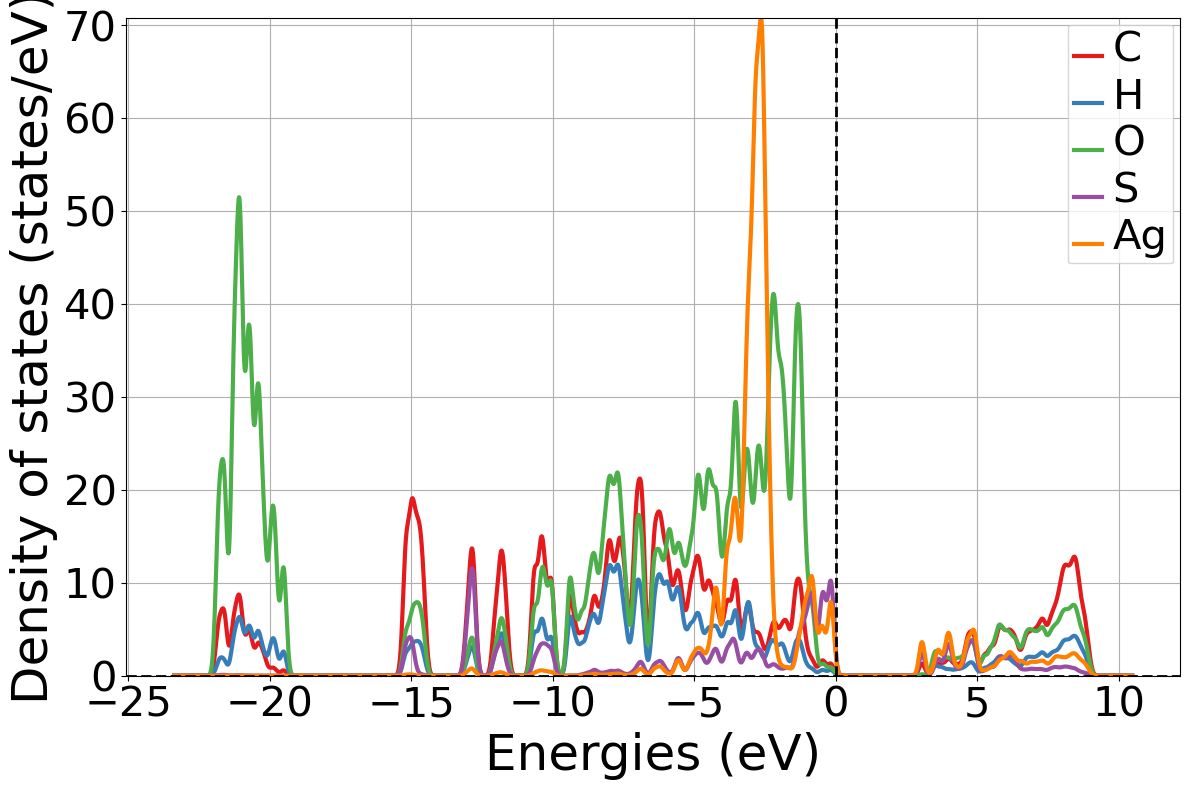

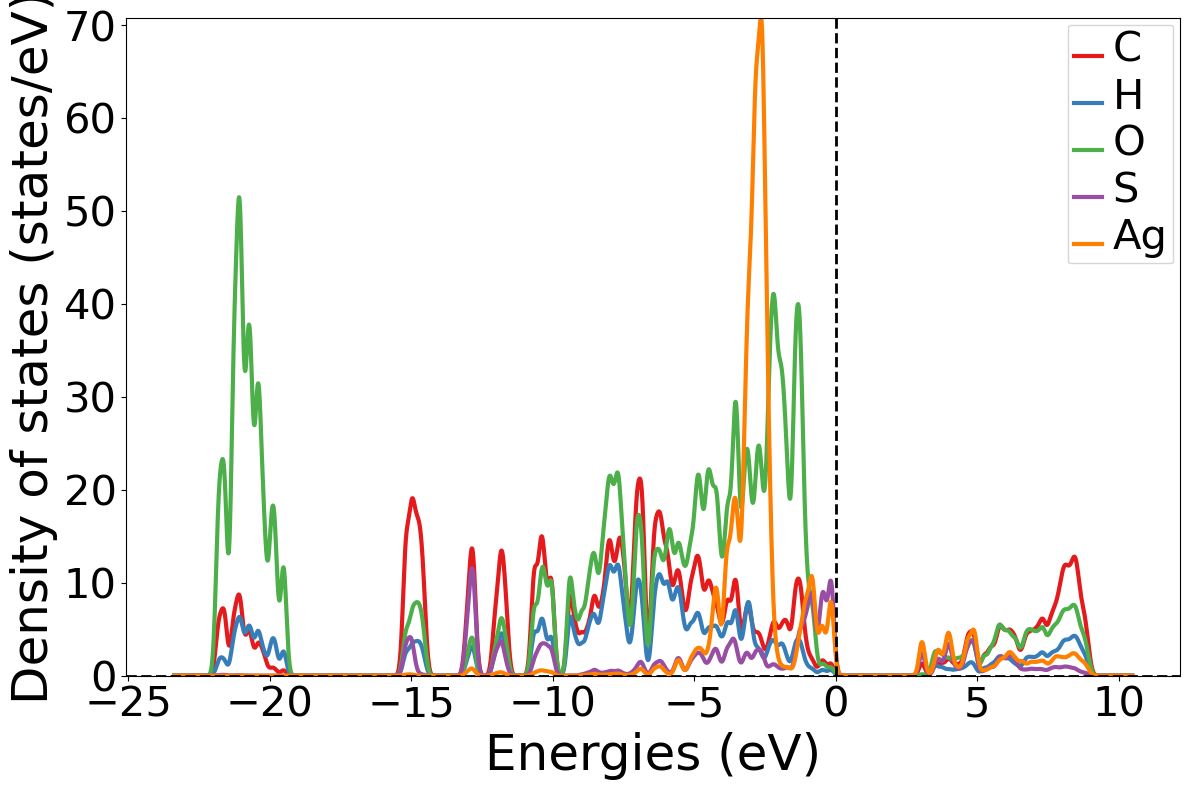

In [16]:
dosplot = DosPlotter(sigma=0.1)
# dosplot.add_dos("Total DOS", dos)
dosplot.add_dos_dict(dos.get_element_dos())
plt = dosplot.get_plot()
plt.grid()
dosplot.save_plot(f"{root}/dos/total_dos.png")

### Plot bandstructure (colored by inorganic and organic interactions)
- orange: inorganic
- black: organic

In [17]:
elements = sort_elements(f"{root}/band/POSCAR")
inorganics = elements[0]
organics = elements[1]

group_dict = [{'elements':inorganics,'color':[255,140,0]},{'elements':organics,'color':[0,0,0]}]
projections = bs.get_projection_on_elements()

bsp = BSPlotter(bs)

proj array,  (1, 458, 110, 5)
proj colors,  (1, 458, 110, 3)
proj colors new,  (1, 458, 11, 10, 3)
proj colors new T,  (1, 11, 458, 10, 3)
Fermi energy 0.39022927


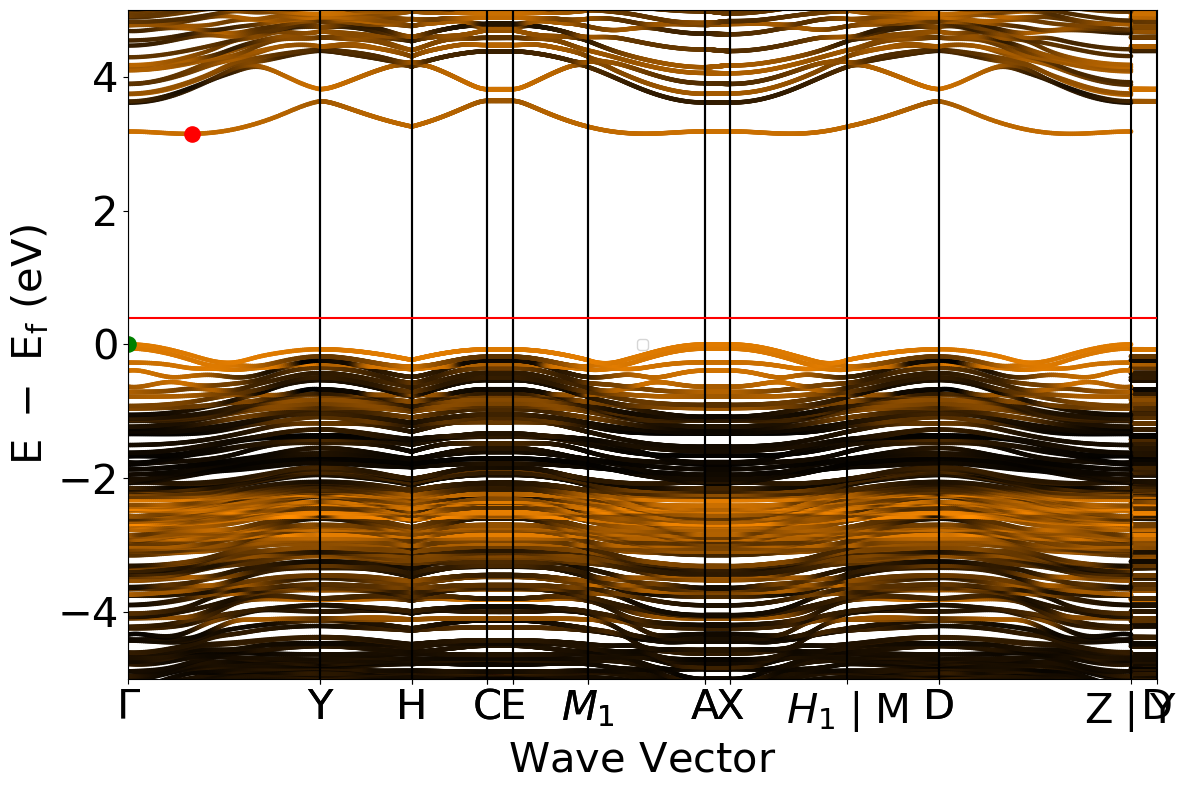

In [18]:
cheese = get_color_grouped(f"{root}/band", bsp, group_dict, smooth=True, marker_size=5, ylim=[-5,5])
# print(cheese)

In [ ]:
proj array,  (1, 458, 110, 5)
proj colors,  (1, 458, 110, 3)
proj colors new,  (1, 458, 11, 10, 3)
proj colors new T,  (1, 11, 458, 10, 3)
Fermi energy 0.39022927
Axes(0.111044,0.145347;0.857202x0.835903)

### Plot Brillouin zone

In [12]:
struct = Structure.from_file(f"{root}/band/POSCAR")

spg_analy =SpacegroupAnalyzer(struct)
prim_struct=spg_analy.get_primitive_standard_structure(international_monoclinic=False)
kpath = HighSymmKpath(prim_struct)
ESplotter.plot_brillouin_zone_from_kpath(kpath, tight_layout=True, savefig=f"{root}/band/brillouin_zone.png")

TypeError: 'NoneType' object is not subscriptable